In [426]:
#!pip install LibRecommender

# 1. Importe de librerias

In [427]:
import numpy as np
import json
import requests
import heapq
import math
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from io import BytesIO
import pickle
import pandas as pd
import time
import kagglehub
import torch
from transformers import BertTokenizer, BertModel
from libreco.data import split_by_ratio_chrono, random_split, DatasetFeat
from libreco.algorithms import DeepFM
from libreco.evaluation import evaluate
import hashlib


# 2. Obtener y trabajar los datos

In [428]:
path = kagglehub.dataset_download("ruchi798/bookcrossing-dataset")

# Users
u_cols = ['user_id', 'location', 'age']
u_path = f'{path}/Book reviews/Book reviews/BX-Users.csv'
users = pd.read_csv(u_path,sep=';',names=u_cols,encoding='latin-1',low_memory=False)[1:]

#Books
i_cols = ['isbn', 'book_title' ,'book_author','year_of_publication', 'publisher', 'img_s', 'img_m', 'img_l']
i_path = f'{path}/Book reviews/Book reviews/BX_Books.csv'
items = pd.read_csv(i_path,sep=';',names=i_cols,encoding='latin-1',low_memory=False)[1:]

#Ratings
r_cols = ['user_id', 'isbn', 'rating']
r_path = f'{path}/Book reviews/Book reviews/BX-Book-Ratings.csv'
ratings = pd.read_csv(r_path,sep=';',names=r_cols,encoding='latin-1',low_memory=False)[1:]

# Preprocessed data with Summary Language and Category for items
d_cols = ['user_id','age','isbn','rating','book_title','book_author','year_of_publication','publisher','img_s','img_m','img_l','Summary','Language','Category','city','state','country']
d_path = f'{path}/Books Data with Category Language and Summary/Preprocessed_data.csv'
data = pd.read_csv(d_path, index_col=0)

In [429]:
def isbn_to_int(isbn):
    """
    Convierte un ISBN (cadena) en un identificador entero único usando hashing.

    :param isbn: ISBN como cadena.
    :return: Identificador único como entero.
    """
    # Asegurarnos de que el ISBN sea una cadena
    isbn_str = str(isbn)

    # Crear un hash usando SHA-256
    hash_object = hashlib.sha256(isbn_str.encode('utf-8'))

    # Convertir el hash a un entero
    hash_int = int(hash_object.hexdigest(), 16)

    # Reducir el tamaño del entero (opcional)
    return hash_int % (10**9)  # Esto asegura un valor de hasta 9 dígitos


users = users.drop(users.index[0])
items = items.drop(items.index[0])
ratings = ratings.drop(ratings.index[0])

users['age'] = users['age'].astype(float)
users['user_id'] = users['user_id'].astype(int)
users.loc[(users.age>99) | (users.age<5),'age'] = np.nan
users.age = users.age.fillna(users.age.mean())
location = users.location.str.split(', ', n=2, expand=True)
location.columns=['city','state','country']
users['city'] = location['city']
users['state'] = location['state']
users['country'] = location['country']


items['year_of_publication'] = items['year_of_publication'].astype(int)
items.loc[items.isbn=='193169656X','publisher']='Mundania Press LLC'
items.loc[items.isbn=='1931696993','publisher']='Novelbooks Incorporated'
items.loc[items.isbn=='9627982032','book_author']='Larissa Anne Downe'
items.loc[(items.year_of_publication==0)|(items.year_of_publication>2008) ,'year_of_publication' ] = np.nan
items.year_of_publication = items.year_of_publication.fillna(round(items.year_of_publication.mean()))
items = items.drop(['img_s', 'img_m', 'img_l'], axis=1)
items = pd.merge(items, data, on='isbn', how='left')
items = items.drop(['user_id','age','rating','book_title_y','book_author_y','year_of_publication_y','publisher_y','city','state','country'],axis=1).drop_duplicates(subset=['isbn'])
items = items.drop(['img_s', 'img_m', 'img_l'], axis=1)
items['book_title'] = items['book_title_x']
items['book_author'] = items['book_author_x']
items['year_of_publication'] = items['year_of_publication_x']
items['publisher'] = items['publisher_x']
items = items.drop(['book_title_x','book_author_x','year_of_publication_x','publisher_x'],axis=1)


ratings['user_id'] = ratings['user_id'].astype(int)
ratings['rating'] = ratings['rating'].astype(int)


data = data.drop(['img_s', 'img_m', 'img_l'], axis=1)
data = data[data['rating'] > 0]
data = data[data['Summary'] != 9]
data = data.reset_index()

# data = data.dropna()
# users = users.dropna()
# items = items.dropna()

items['isbn-int'] = items['isbn'].apply(isbn_to_int)
data['isbn-int'] = data['isbn'].apply(isbn_to_int)
users = users[users['user_id'].isin(data['user_id'])]
items = items[items['isbn'].isin(data['isbn'])]


best_rated_items = data.groupby('isbn')['rating'].mean().reset_index().sort_values(by='rating', ascending=False)
most_popular_items = data.groupby('isbn').size().reset_index(name='rating_count').sort_values(by='rating_count', ascending=False)

# 3. Train-Test Split

In [430]:
R = 0.05
MIN_RATINGS = 5


users, _ = train_test_split(users, test_size=1-R, random_state=42)
data = data[data['user_id'].isin(users['user_id'])]
user_id_counts = data['user_id'].value_counts()
data_high = data[data['user_id'].isin(user_id_counts[user_id_counts >= MIN_RATINGS].index)]
data_low = data[data['user_id'].isin(user_id_counts[user_id_counts < MIN_RATINGS].index)]
items = items[items['isbn'].isin(data['isbn'])]

In [431]:
# 0.7 - 0.15 - 0.15 objetivo
train_data, test_data = train_test_split(data_high, stratify=data_high['user_id'], test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)
train_data = pd.concat([train_data, data_low]).reset_index()

print(len(train_data)/(len(train_data)+len(val_data)+len(test_data)), len(val_data)/(len(train_data)+len(val_data)+len(test_data)), len(test_data)/(len(train_data)+len(val_data)+len(test_data)))

0.7541400724512679 0.1229084008970157 0.12295152665171641


In [432]:
train_user_ratings = {user_id: train_data[train_data['user_id']==user_id].sort_values(by='rating', ascending=False) for user_id in users['user_id']}
users = users[users['user_id'].isin(data_high['user_id'])] ###
val_user_ratings = {user_id: val_data[val_data['user_id']==user_id].sort_values(by='rating', ascending=False) for user_id in users['user_id']}
test_user_ratings = {user_id: test_data[test_data['user_id']==user_id].sort_values(by='rating', ascending=False) for user_id in users['user_id']}

In [433]:
train_data_for_deep = pd.concat(train_user_ratings.values())
train_data_for_deep = train_data_for_deep.drop(['Summary','Language','Category','city', "state", "index", "location","book_title", "book_author", "publisher", "isbn"],axis=1)

train_data_for_deep = train_data_for_deep[['user_id', 'isbn-int', 'rating', 'age', 'year_of_publication', "country"]]
train_data_for_deep = train_data_for_deep.rename(columns={"isbn-int": "item", "user_id": "user", "rating": "label"})

train_data_for_deep['country'] = train_data_for_deep['country'].fillna('unknown')

# labels menores a 7 se consideran negativos con 0 y mayores a 7 positivos con 1
#train_data_for_deep['label'] = train_data_for_deep['label'].apply(lambda x: 1 if x > 7 else 0)

train_data_for_deep.head()

,user,item,label,age,year_of_publication,country
8058,60336,353497721,8,49.0000,2003.0,usa
10934,60336,763877822,7,49.0000,2003.0,usa
7179,60336,165766284,5,49.0000,2003.0,usa
16626,103175,53294078,7,14.0000,1997.0,canada
15804,16528,345248784,10,34.7439,1994.0,usa


In [434]:
test_data_for_deep = pd.concat(test_user_ratings.values())
test_data_for_deep = test_data_for_deep.drop(['Summary','Language','Category','city', "state", "index", "location","book_title", "book_author", "publisher", "isbn"],axis=1)

test_data_for_deep = test_data_for_deep[['user_id', 'isbn-int', 'rating', 'age', 'year_of_publication', "country"]]
test_data_for_deep = test_data_for_deep.rename(columns={"isbn-int": "item", "user_id": "user", "rating": "label"})

# print null values
print(test_data_for_deep.isnull().sum())
test_data_for_deep['country'] = test_data_for_deep['country'].fillna('unknown')


# labels menores a 7 se consideran negativos con 0 y mayores a 7 positivos con 1
#test_data_for_deep['label'] = test_data_for_deep['label'].apply(lambda x: 1 if x > 7 else 0)

test_data_for_deep.head()


user                      0
item                      0
label                     0
age                       0
year_of_publication       0
country                1100
dtype: int64


,user,item,label,age,year_of_publication,country
26632,60336,663889941,8,49.0000,2001.0,usa
366567,203280,254105161,8,28.0000,1987.0,australia
232550,203280,560728630,8,28.0000,1993.0,australia
236731,203280,575196647,7,28.0000,2001.0,australia
26985,94495,111887454,6,34.7439,2003.0,usa


In [ ]:
val_data_for_deep = pd.concat(val_user_ratings.values())
val_data_for_deep = val_data_for_deep.drop(['Summary','Language','Category','city', "state", "index", "location","book_title", "book_author", "publisher", "isbn"],axis=1)

val_data_for_deep = val_data_for_deep[['user_id', 'isbn-int', 'rating', 'age', 'year_of_publication', "country"]]
val_data_for_deep = val_data_for_deep.rename(columns={"isbn-int": "item", "user_id": "user", "rating": "label"})

print(val_data_for_deep.isnull().sum())
val_data_for_deep['country'] = val_data_for_deep['country'].fillna('unknown')


# labels menores a 7 se consideran negativos con 0 y mayores a 7 positivos con 1
#val_data_for_deep['label'] = val_data_for_deep['label'].apply(lambda x: 1 if x > 7 else 0)

val_data_for_deep.head()

user                      0
item                      0
label                     0
age                       0
year_of_publication       0
country                1066
dtype: int64


,user,item,label,age,year_of_publication,country
7704,60336,556066670,1,49.0,2003.0,usa
353669,205448,537858722,1,22.0,2002.0,italy
29237,205448,167277000,1,22.0,2001.0,italy
197180,205448,410244665,1,22.0,2002.0,italy
366559,203280,962623350,1,28.0,1998.0,australia


In [436]:
users_train = train_data_for_deep['user'].unique()
users_test = test_data_for_deep['user'].unique()

unique_values = set(users_test) - set(users_train)

if unique_values:
    print('Users in testing data but not in training data:', unique_values)
else:
    print('All users in testing data are in training data')

All users in testing data are in training data


In [437]:
items_train = train_data_for_deep['item'].unique()
items_test = test_data_for_deep['item'].unique()

unique_values_items = set(items_test) - set(items_train)

if unique_values_items:
    print('Items in testing data but not in training data:', unique_values_items)
else:
    print('All users in testing data are in training data')

Items in testing data but not in training data: {985448456, 289636362, 241319950, 852434964, 229810200, 218816538, 343539745, 555016226, 243613731, 149176366, 288022583, 148807739, 825221198, 458104910, 547070038, 259727450, 404521051, 478396510, 289824864, 707453026, 686768230, 330465388, 778780781, 401809518, 329138290, 987922548, 91078781, 348766348, 507863184, 282468497, 929128596, 934224025, 905109660, 344580257, 368861350, 13058225, 199467187, 83296440, 71696576, 386064577, 635379907, 107954371, 658170053, 684908741, 537075911, 885047496, 833913041, 400466130, 972636375, 549585114, 116719834, 7094494, 494575846, 809869543, 694042857, 568852717, 378151154, 405577987, 55042310, 845775110, 934715654, 57532683, 105906448, 120226065, 251347218, 110608671, 474505508, 6881573, 198533414, 321995047, 975757618, 574914875, 254615867, 420159804, 870138178, 72982872, 181559640, 181379422, 957587808, 257778017, 819642725, 646848878, 604946806, 467394936, 270942585, 587497851, 312443262, 62228

In [438]:
test_data_for_deep = test_data_for_deep[~test_data_for_deep["item"].isin(unique_values_items)].reset_index(drop=True)
test_data_for_deep.head()

,user,item,label,age,year_of_publication,country
0,60336,663889941,8,49.0000,2001.0,usa
1,203280,575196647,7,28.0000,2001.0,australia
2,94495,111887454,6,34.7439,2003.0,usa
3,234901,945709830,6,49.0000,2003.0,usa
4,234901,612712436,6,49.0000,1999.0,usa


# 4. Métricas

In [ ]:
# Métricas de evaluación
# Obtenido de https://gist.github.com/bwhite/3726239

def precision_at_k(r, k):
    assert k >= 1
    r = np.asarray(r)[:k] != 0
    if r.size != k:
        raise ValueError('Relevance score length < k')
    return np.mean(r)

def average_precision(r):
    r = np.asarray(r) != 0
    out = [precision_at_k(r, k + 1) for k in range(r.size) if r[k]]
    if not out:
        return 0.
    return np.mean(out)

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.


def ndcg_at_k(r, k):
    idcg = dcg_at_k(sorted(r, reverse=True), k)

    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def recall_at_k(relevant_items, recommended_items, k):
  relevant_items = set(relevant_items)
  recommended_items = set(recommended_items)
  intersection = relevant_items.intersection(recommended_items)
  recall = len(intersection) / len(relevant_items) if len(relevant_items) > 0 else 0
  return recall

def diversidad(rec):
  categorias_recomendadas = items[items['isbn'].isin(rec)]['Category']
  categorias_unicas = len(set(categorias_recomendadas))
  return categorias_unicas / len(rec)


items_popularity = (data['isbn'].value_counts()/len(train_data)).to_dict()
def novedad(rec):
  novedad_usuario = 0
  for item in rec:
    novedad_usuario += np.log(1 / items_popularity[item])
  return novedad_usuario / len(rec)


# 5. Modelos

# Bert

In [440]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_embedding(obj):
  text = ""
  if isinstance(obj, str):
    text = str(obj)
  else:
    print(type(obj))
    return None
  inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=256)

  with torch.no_grad():
    try:
      outputs = model(**inputs)
    except Exception as e:
      print(e)
      outputs = False

  embedding = outputs.last_hidden_state.mean(dim=1).squeeze() if outputs else None

  return embedding

In [441]:
loaded_items = None
try:
  with open(f'./items-embeddings.pkl', 'rb') as f:
    loaded_items = pickle.load(f)
except:
  loaded_items = None

wanted_items = items[~items['isbn'].isin(loaded_items['isbn'])] if isinstance(loaded_items, pd.DataFrame) else items
print(len(wanted_items))
wanted_items['Summary_embedding'] = wanted_items['Summary'].apply(get_embedding)



0


In [442]:
items = pd.concat([loaded_items, wanted_items]).reset_index()

items = items.dropna().drop('index', axis=1)

with open(f'./items-embeddings.pkl', 'wb') as f:
  pickle.dump(items, f)

In [443]:
with open(f'./items-embeddings.pkl', 'rb') as f:
  items = pickle.load(f)
  items = items[items['isbn'].isin(data['isbn'])]

In [444]:
summary_embeddings = np.stack(items['Summary_embedding'].apply(lambda x: x.numpy()))

In [445]:
similitudes = pairwise_distances(summary_embeddings)

In [ ]:
class TextBased:
  def recommend(self, user_id, topk=10):
    recomendaciones = []
    # recomendamos al usuario items similares al que mejor ha puntuado
    user_ratings = train_user_ratings[user_id]
    if len(user_ratings) > topk:
      user_ratings = user_ratings[:topk]
    # mas cercanos al mejor puntuado
    try:
      recommended_items = []
      user_isbn = user_ratings['isbn'].iloc[0]
      user_isbn_idx = items[items['isbn'] == user_isbn].index[0]
      result = np.column_stack([items['isbn'], similitudes[user_isbn_idx]])
      result = result[result[:, 1].argsort()[::-1]]
      recommended_items = result.tolist()
      recommended_items = sorted(recommended_items, key=lambda x: x[1])[1:topk+1]
      recomendaciones += [item[0] for item in recommended_items]
    except Exception as e:
      print(e)

    return recomendaciones

text_based_recommender = TextBased()

# Most Popular

In [447]:
class MostPopularRecommender:
  def __init__(self):
    self.items = None

  def train(self, training_set):
    tset = training_set[:]
    self.items = tset['isbn'].value_counts()

  def recommend(self, user, topk: int):
    return list(self.items.index)[:topk]

most_popular_recommender = MostPopularRecommender()
most_popular_recommender.train(train_data)

# Deep FM

In [448]:
# Revisar usuarios desconocidos
unknown_users = set(test_data_for_deep['user']) - set(train_data_for_deep['user'])
print("Usuarios desconocidos:", unknown_users)

# Revisar ítems desconocidos
unknown_items = set(test_data_for_deep['item']) - set(train_data_for_deep['item'])
print("Ítems desconocidos:", unknown_items)

Usuarios desconocidos: set()
Ítems desconocidos: set()


In [ ]:
from libreco.data import DatasetFeat
from libreco.algorithms import DeepFM
from libreco.evaluation import evaluate


sparse_col = ["country"]
dense_col = ["age", "year_of_publication"]
user_col = ["age", "country"]
item_col = ["year_of_publication"]

train_data_deep, data_info = DatasetFeat.build_trainset(train_data_for_deep, user_col, item_col, sparse_col, dense_col)
test_data_deep = DatasetFeat.build_testset(test_data_for_deep)

import tensorflow as tf
tf.compat.v1.reset_default_graph()
model = DeepFM(
    task="ranking",
    data_info=data_info,
    embed_size=16,
    n_epochs=15,
    lr=1e-4,
    batch_size=256,
    use_bn=True,
    hidden_units=(128, 64, 32),
)
model.fit(
    train_data_deep,
    neg_sampling=True,
    verbose=2,
    shuffle=True,
    eval_data=test_data_deep,
    metrics=["loss"],
)

eval_result_test = evaluate(model, test_data_deep, neg_sampling=True, metrics=["ndcg", "recall", "map"])

print(eval_result_test)


[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Training start time: 2024-12-04 00:48:44
total params: 319,348 | embedding params: 298,270 | network params: 21,078


/opt/homebrew/lib/python3.11/site-packages/libreco/layers/dense.py:31: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
/opt/homebrew/lib/python3.11/site-packages/libreco/layers/dense.py:39: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  net = tf.layers.batch_normalization(net, training=is_training)
train: 100%|██████████| 137/137 [00:00<00:00, 256.45it/s]


Epoch 1 elapsed: 0.536s
	 train_loss: 1608.8495


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 22.55it/s]


	 eval log_loss: 18.0218


train: 100%|██████████| 137/137 [00:00<00:00, 408.30it/s]


Epoch 2 elapsed: 0.336s
	 train_loss: 180.8661


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 238.95it/s]


	 eval log_loss: 11.9439


train: 100%|██████████| 137/137 [00:00<00:00, 402.84it/s]


Epoch 3 elapsed: 0.342s
	 train_loss: 9.2856


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 296.29it/s]


	 eval log_loss: 4.9336


train: 100%|██████████| 137/137 [00:00<00:00, 426.70it/s]


Epoch 4 elapsed: 0.322s
	 train_loss: 5.0397


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 343.15it/s]


	 eval log_loss: 3.4480


train: 100%|██████████| 137/137 [00:00<00:00, 419.99it/s]


Epoch 5 elapsed: 0.327s
	 train_loss: 3.054


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 430.10it/s]


	 eval log_loss: 3.0884


train: 100%|██████████| 137/137 [00:00<00:00, 335.06it/s]


Epoch 6 elapsed: 0.410s
	 train_loss: 2.7934


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 294.46it/s]


	 eval log_loss: 1.8164


train: 100%|██████████| 137/137 [00:00<00:00, 277.07it/s]


Epoch 7 elapsed: 0.497s
	 train_loss: 2.5174


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 231.42it/s]


	 eval log_loss: 1.2974


train: 100%|██████████| 137/137 [00:00<00:00, 289.13it/s]


Epoch 8 elapsed: 0.475s
	 train_loss: 2.3297


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 295.44it/s]


	 eval log_loss: 2.9098


train: 100%|██████████| 137/137 [00:00<00:00, 328.22it/s]


Epoch 9 elapsed: 0.418s
	 train_loss: 2.1961


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 270.79it/s]


	 eval log_loss: 1.6889


train: 100%|██████████| 137/137 [00:00<00:00, 413.59it/s]


Epoch 10 elapsed: 0.332s
	 train_loss: 2.2299


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 409.48it/s]


	 eval log_loss: 1.8071


train: 100%|██████████| 137/137 [00:00<00:00, 344.75it/s]


Epoch 11 elapsed: 0.398s
	 train_loss: 1.9569


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 225.73it/s]


	 eval log_loss: 2.6132


train: 100%|██████████| 137/137 [00:00<00:00, 305.54it/s]


Epoch 12 elapsed: 0.449s
	 train_loss: 2.0659


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 311.91it/s]


	 eval log_loss: 1.8297


train: 100%|██████████| 137/137 [00:00<00:00, 298.12it/s]


Epoch 13 elapsed: 0.461s
	 train_loss: 1.7555


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 408.17it/s]


	 eval log_loss: 2.2769


train: 100%|██████████| 137/137 [00:00<00:00, 389.71it/s]


Epoch 14 elapsed: 0.353s
	 train_loss: 1.6181


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 376.64it/s]


	 eval log_loss: 1.8308


train: 100%|██████████| 137/137 [00:00<00:00, 342.97it/s]


Epoch 15 elapsed: 0.400s
	 train_loss: 1.2848


eval_pointwise: 100%|██████████| 1/1 [00:00<00:00, 358.67it/s]


	 eval log_loss: 2.4708


eval_listwise: 100%|██████████| 328/328 [00:04<00:00, 75.40it/s]

{'ndcg': 0.010420163105953879, 'recall': 0.010598141695702671, 'map': 0.007876016335879884}


In [450]:
class DeepFMRecommender:
    def __init__(self, model):
        self.model = model

    def recommend(self, user, topk):
        return model.recommend_user(user, topk)[user]

In [451]:
deepfm_recommender = DeepFMRecommender(model)

# 6. Evaluación

In [452]:
start = time.time()




topk = 10

l = len(test_user_ratings)
for recfunc in [
    text_based_recommender.recommend,
    most_popular_recommender.recommend
]:
  map = 0.
  mean_ndcg = 0.
  mean_recall = 0.
  mean_diversity = 0.
  mean_novelty = 0.
  for i in range(l):
    u = users['user_id'].iloc[i]
    rec = recfunc(u, topk=topk)
    rel_vector = np.isin(rec, test_user_ratings[u]['isbn'], assume_unique=True).astype(int)
    try:
      map += average_precision(rel_vector)
      mean_ndcg += ndcg_at_k(rel_vector, topk)
      mean_recall += recall_at_k(test_user_ratings[u]['isbn'], rec, topk)
      mean_diversity += diversidad(rec)
      mean_novelty += novedad(rec)

      time_taken = round(time.time() - start, 2)
      if i % 100 == 0:
        print(f'\r{time_taken} - {i}/{l} - {u} - {map/(1+i)} - {mean_ndcg/(1+i)} - {mean_recall/(1+i)} - {rec}', end='')
    except Exception as e:
      print('Errore:', e)



  map /= l
  mean_ndcg /= l
  mean_recall /= l
  mean_diversity /= l
  mean_novelty /= l


  time_taken = time.time() - start

  print('\nMAP ',map)
  print('ndcg@10' ,mean_ndcg)
  print('recall@10', mean_recall)
  print('diversity', mean_diversity)
  print('novelty', mean_novelty)

  print('tiempo de ejecucion {0:.2f} segs'.format(time_taken))

12.96 - 600/626 - 213628 - 0.004853022739877982 - 0.007168120509857398 - 0.004869284298992954 - ['0786222743', '0439136350', '0765341581', '043935806X', '0312857063', '0345381688', '0380471752', '0020869207', '0553563696', '0812522494']]
MAP  0.004836705715299965
ndcg@10 0.0073627323036553945
recall@10 0.005473546108138602
diversity 0.2581469648562288
novelty 9.618262455449548
tiempo de ejecucion 13.43 segs
14.17 - 600/626 - 213628 - 0.011133560468003062 - 0.014345792254433548 - 0.007671562801493308 - ['0316666343', '0971880107', '0385504209', '0312195516', '0345337662', '059035342X', '044651652X', '044023722X', '0060976845', '0440241073']]
MAP  0.010688929458897508
ndcg@10 0.013772877228298024
recall@10 0.0073651904851397415
diversity 0.30000000000000226
novelty 6.734560275149216
tiempo de ejecucion 14.20 segs


In [453]:
# MAP  0.011462205700123917
# ndcg@10 0.012325148240839141
# recall@10 0.0072048150115064605
# diversity 0.2857142857142821
# novelty 0.0
# tiempo de ejecucion 47.80 segs

# Ensamble

In [454]:
def hash_to_isbn(df_with_info, hashed_int):
    return df_with_info[df_with_info['isbn-int'] == hashed_int]['isbn'].iloc[0]

In [464]:
def recommend_ensamble(user, topk=10, weights=[3, 4, 3]):
  rec = []
  recfuncs = [text_based_recommender.recommend, most_popular_recommender.recommend, deepfm_recommender.recommend]
  #recfuncs = [text_based_recommender.recommend, most_popular_recommender.recommend]
  #weights = [5,5]
  for i in range(len(recfuncs)):
    recfunc, weight = recfuncs[i], weights[i]
    recomendation = recfunc(user, topk=topk)[:weight]
    if i == 2:
      recomendation = [hash_to_isbn(items, item) for item in recomendation]
    rec.extend(recomendation)
  return rec

In [466]:

start = time.time()




topk = 10

l = len(test_user_ratings)
map = 0.
mean_ndcg = 0.
mean_recall = 0.
mean_diversity = 0.
mean_novelty = 0.
for i in range(l):
  u = users['user_id'].iloc[i]
  rec = recommend_ensamble(u, topk=topk, weights=[1, 7, 2])
  rel_vector = np.isin(rec, test_user_ratings[u]['isbn'], assume_unique=True).astype(int)
  try:
    map += average_precision(rel_vector)
    mean_ndcg += ndcg_at_k(rel_vector, topk)
    mean_recall += recall_at_k(test_user_ratings[u]['isbn'], rec, topk)
    mean_diversity += diversidad(rec)
    mean_novelty += novedad(rec)

    time_taken = round(time.time() - start, 2)
    if i % 100 == 0:
      print(f'\r{time_taken} - {i}/{l} - {u} - {map/(1+i)} - {mean_ndcg/(1+i)} - {mean_recall/(1+i)} - {rec}', end='')
  except Exception as e:
    print('Errore:', e)



map /= l
mean_ndcg /= l
mean_recall /= l
mean_diversity /= l
mean_novelty /= l


time_taken = time.time() - start

print("\nENSAMBLE")
print("------------")
print('\nMAP ',map)
print('ndcg@10' ,mean_ndcg)
print('recall@10', mean_recall)
print('diversity', mean_diversity)
print('novelty', mean_novelty)

print('tiempo de ejecucion {0:.2f} segs'.format(time_taken))

19.53 - 600/626 - 213628 - 0.008032908116102792 - 0.012097110268302546 - 0.00738038143710063 - ['0786222743', '0316666343', '0971880107', '0385504209', '0312195516', '0345337662', '059035342X', '044651652X', '0060915153', '3548208975']]
ENSAMBLE
------------

MAP  0.00771210507632233
ndcg@10 0.011613998835862348
recall@10 0.00708563776948479
diversity 0.3646964856230068
novelty 7.292386222240849
tiempo de ejecucion 20.27 segs


In [467]:
from collections import Counter

def recommend_voting(user, topk=10, weights=[1, 1, 1]):
    recfuncs = [text_based_recommender.recommend, 
                most_popular_recommender.recommend, 
                deepfm_recommender.recommend]
    
    vote_counter = Counter()
    
    for i, recfunc in enumerate(recfuncs):
        weight = weights[i]
        recommendations = recfunc(user, topk=topk)
        
        # Si es el modelo DeepFM, ajusta los ítems
        if i == 2:
            recommendations = [hash_to_isbn(items, item) for item in recommendations]
        
        # Añadir votos al contador según el peso y posición
        for rank, item in enumerate(recommendations):
            vote_counter[item] += weight / (rank + 1)  # Votos ponderados por posición
    
    # Obtener los top-k ítems con más votos
    top_recommendations = [item for item, _ in vote_counter.most_common(topk)]
    return top_recommendations

In [468]:
map = 0.
mean_ndcg = 0.
mean_recall = 0.
mean_diversity = 0.
mean_novelty = 0.

start = time.time()
for i in range(l):
    u = users['user_id'].iloc[i]
    rec = recommend_voting(u, topk=topk,weights=[2,7,1])  # Usa la función de votación
    rel_vector = np.isin(rec, test_user_ratings[u]['isbn'], assume_unique=True).astype(int)
    try:
        map += average_precision(rel_vector)
        mean_ndcg += ndcg_at_k(rel_vector, topk)
        mean_recall += recall_at_k(test_user_ratings[u]['isbn'], rec, topk)
        mean_diversity += diversidad(rec)
        mean_novelty += novedad(rec)

        time_taken = round(time.time() - start, 2)

        if i % 100 == 0:
            print(f'\r{time_taken} - {i}/{l} - {u} - {map/(1+i)} - {mean_ndcg/(1+i)} - {mean_recall/(1+i)} - {rec}', end='')
    except Exception as e:
        print('Errore:', e)

map /= l
mean_ndcg /= l
mean_recall /= l
mean_diversity /= l
mean_novelty /= l

time_taken = time.time() - start

print("\nVOTING")
print("------------")
print('\nMAP ',map)
print('ndcg@10' ,mean_ndcg)
print('recall@10', mean_recall)
print('diversity', mean_diversity)
print('novelty', mean_novelty)

print('tiempo de ejecucion {0:.2f} segs'.format(time_taken))

20.38 - 600/626 - 213628 - 0.011240525050841188 - 0.014777038566845818 - 0.009127469623456704 - ['0316666343', '0971880107', '0385504209', '0786222743', '0312195516', '0345337662', '059035342X', '0439136350', '044651652X', '0060915153']
VOTING
------------

MAP  0.010791622293219736
ndcg@10 0.014186901243888715
recall@10 0.008762954063414504
diversity 0.36246006389776697
novelty 7.419002123514509
tiempo de ejecucion 21.16 segs


In [463]:
from collections import Counter
import time


weight_combinations = [
    [1,1,8], [1,2,7], [1,3,6], [1,4,5], [1,5,4], [1,6,3], [1,7,2], [1,8,1],
    [2,1,7], [2,2,6], [2,3,5], [2,4,4], [2,5,3], [2,6,2], [2,7,1],
    [3,1,6], [3,2,5], [3,3,4], [3,4,3], [3,5,2], [3,6,1],
    [4,1,5], [4,2,4], [4,3,3], [4,4,2], [4,5,1],
    [5,1,4], [5,2,3], [5,3,2], [5,4,1],
    [6,1,3], [6,2,2], [6,3,1],
    [7,1,2], [7,2,1],
    [8,1,1]
]

# Variables para guardar los mejores resultados
best_weights = None
best_map = 0

# Iterar sobre todas las combinaciones de pesos que sumen 10
for weights in weight_combinations:
    # Evaluar métricas con los pesos actuales
    map = 0.0
    start = time.time()
    for i in range(len(test_user_ratings)):
        u = users['user_id'].iloc[i]
        rec = recommend_voting(u, topk=10, weights=weights)
        rel_vector = np.isin(rec, test_user_ratings[u]['isbn'], assume_unique=True).astype(int)
        try:
            map += average_precision(rel_vector)
        except Exception as e:
            print(f'Error en el usuario {u}:', e)

    # Promedio MAP para estos pesos
    map /= len(test_user_ratings)

    # Comparar con el mejor resultado
    if map > best_map:
        best_map = map
        best_weights = weights

    # Reporte intermedio
    print(f'Pesos: {weights}, MAP: {map:.4f}, Mejor MAP: {best_map:.4f}, Mejor Pesos: {best_weights}')

# Resultados finales
print("\nMejor configuración de pesos:")
print(f'Pesos: {best_weights}, MAP: {best_map:.4f}')


Pesos: [1, 1, 8], MAP: 0.0048, Mejor MAP: 0.0048, Mejor Pesos: [1, 1, 8]
Pesos: [1, 2, 7], MAP: 0.0056, Mejor MAP: 0.0056, Mejor Pesos: [1, 2, 7]
Pesos: [1, 3, 6], MAP: 0.0066, Mejor MAP: 0.0066, Mejor Pesos: [1, 3, 6]
Pesos: [1, 4, 5], MAP: 0.0072, Mejor MAP: 0.0072, Mejor Pesos: [1, 4, 5]
Pesos: [1, 5, 4], MAP: 0.0094, Mejor MAP: 0.0094, Mejor Pesos: [1, 5, 4]
Pesos: [1, 6, 3], MAP: 0.0100, Mejor MAP: 0.0100, Mejor Pesos: [1, 6, 3]
Pesos: [1, 7, 2], MAP: 0.0103, Mejor MAP: 0.0103, Mejor Pesos: [1, 7, 2]
Pesos: [1, 8, 1], MAP: 0.0107, Mejor MAP: 0.0107, Mejor Pesos: [1, 8, 1]
Pesos: [2, 1, 7], MAP: 0.0054, Mejor MAP: 0.0107, Mejor Pesos: [1, 8, 1]
Pesos: [2, 2, 6], MAP: 0.0064, Mejor MAP: 0.0107, Mejor Pesos: [1, 8, 1]
Pesos: [2, 3, 5], MAP: 0.0070, Mejor MAP: 0.0107, Mejor Pesos: [1, 8, 1]
Pesos: [2, 4, 4], MAP: 0.0093, Mejor MAP: 0.0107, Mejor Pesos: [1, 8, 1]
Pesos: [2, 5, 3], MAP: 0.0101, Mejor MAP: 0.0107, Mejor Pesos: [1, 8, 1]
Pesos: [2, 6, 2], MAP: 0.0104, Mejor MAP: 0.0107, M

In [465]:
from collections import Counter
import time

print("Ensamble weights")
weight_combinations = [
    [1,1,8], [1,2,7], [1,3,6], [1,4,5], [1,5,4], [1,6,3], [1,7,2], [1,8,1],
    [2,1,7], [2,2,6], [2,3,5], [2,4,4], [2,5,3], [2,6,2], [2,7,1],
    [3,1,6], [3,2,5], [3,3,4], [3,4,3], [3,5,2], [3,6,1],
    [4,1,5], [4,2,4], [4,3,3], [4,4,2], [4,5,1],
    [5,1,4], [5,2,3], [5,3,2], [5,4,1],
    [6,1,3], [6,2,2], [6,3,1],
    [7,1,2], [7,2,1],
    [8,1,1]
]

# Variables para guardar los mejores resultados
best_weights = None
best_map = 0

# Iterar sobre todas las combinaciones de pesos que sumen 10
for weights in weight_combinations:
    # Evaluar métricas con los pesos actuales
    map = 0.0
    start = time.time()
    for i in range(len(test_user_ratings)):
        u = users['user_id'].iloc[i]
        rec = recommend_ensamble(u, topk=10, weights=weights)
        rel_vector = np.isin(rec, test_user_ratings[u]['isbn'], assume_unique=True).astype(int)
        try:
            map += average_precision(rel_vector)
        except Exception as e:
            print(f'Error en el usuario {u}:', e)

    # Promedio MAP para estos pesos
    map /= len(test_user_ratings)

    # Comparar con el mejor resultado
    if map > best_map:
        best_map = map
        best_weights = weights

    # Reporte intermedio
    print(f'Pesos: {weights}, MAP: {map:.4f}, Mejor MAP: {best_map:.4f}, Mejor Pesos: {best_weights}')

# Resultados finales
print("\nMejor configuración de pesos:")
print(f'Pesos: {best_weights}, MAP: {best_map:.4f}')

Ensamble weights
Pesos: [1, 1, 8], MAP: 0.0060, Mejor MAP: 0.0060, Mejor Pesos: [1, 1, 8]
Pesos: [1, 2, 7], MAP: 0.0064, Mejor MAP: 0.0064, Mejor Pesos: [1, 2, 7]
Pesos: [1, 3, 6], MAP: 0.0066, Mejor MAP: 0.0066, Mejor Pesos: [1, 3, 6]
Pesos: [1, 4, 5], MAP: 0.0066, Mejor MAP: 0.0066, Mejor Pesos: [1, 3, 6]
Pesos: [1, 5, 4], MAP: 0.0073, Mejor MAP: 0.0073, Mejor Pesos: [1, 5, 4]
Pesos: [1, 6, 3], MAP: 0.0074, Mejor MAP: 0.0074, Mejor Pesos: [1, 6, 3]
Pesos: [1, 7, 2], MAP: 0.0077, Mejor MAP: 0.0077, Mejor Pesos: [1, 7, 2]
Pesos: [1, 8, 1], MAP: 0.0075, Mejor MAP: 0.0077, Mejor Pesos: [1, 7, 2]
Pesos: [2, 1, 7], MAP: 0.0064, Mejor MAP: 0.0077, Mejor Pesos: [1, 7, 2]
Pesos: [2, 2, 6], MAP: 0.0068, Mejor MAP: 0.0077, Mejor Pesos: [1, 7, 2]
Pesos: [2, 3, 5], MAP: 0.0068, Mejor MAP: 0.0077, Mejor Pesos: [1, 7, 2]
Pesos: [2, 4, 4], MAP: 0.0069, Mejor MAP: 0.0077, Mejor Pesos: [1, 7, 2]
Pesos: [2, 5, 3], MAP: 0.0076, Mejor MAP: 0.0077, Mejor Pesos: [1, 7, 2]
Pesos: [2, 6, 2], MAP: 0.0075, Mej

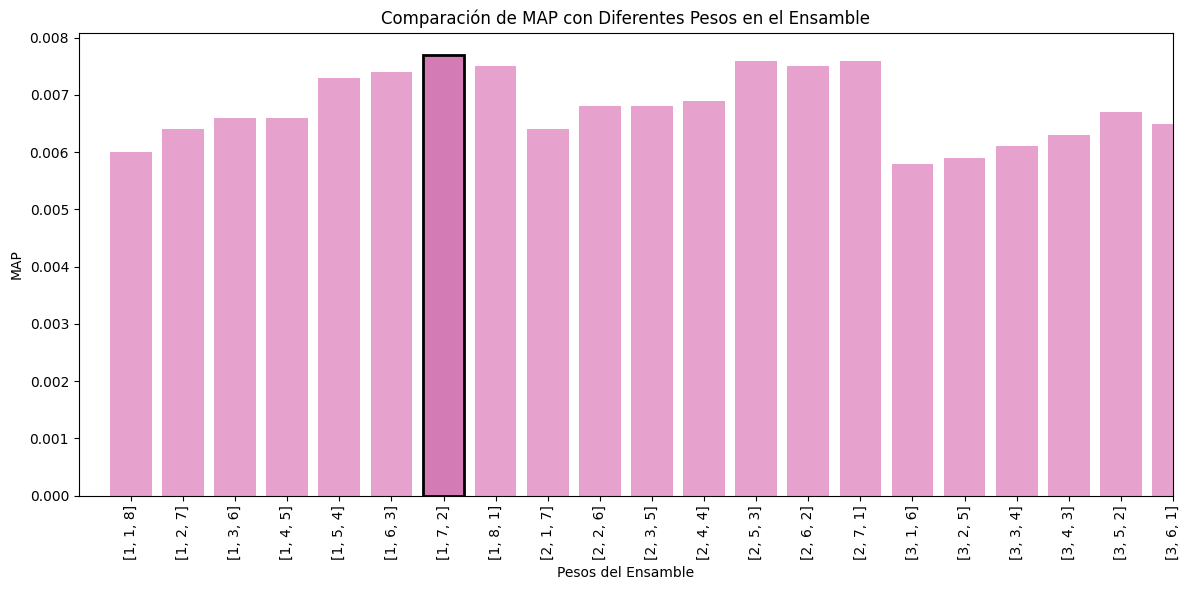

In [9]:
import matplotlib.pyplot as plt

# Datos de pesos y MAP
pesos = ['[1, 1, 8]', '[1, 2, 7]', '[1, 3, 6]', '[1, 4, 5]', '[1, 5, 4]', '[1, 6, 3]', '[1, 7, 2]',
         '[1, 8, 1]', '[2, 1, 7]', '[2, 2, 6]', '[2, 3, 5]', '[2, 4, 4]', '[2, 5, 3]', '[2, 6, 2]',
         '[2, 7, 1]', '[3, 1, 6]', '[3, 2, 5]', '[3, 3, 4]', '[3, 4, 3]', '[3, 5, 2]', '[3, 6, 1]',
         '[4, 1, 5]', '[4, 2, 4]', '[4, 3, 3]', '[4, 4, 2]', '[4, 5, 1]', '[5, 1, 4]', '[5, 2, 3]',
         '[5, 3, 2]', '[5, 4, 1]', '[6, 1, 3]', '[6, 2, 2]', '[6, 3, 1]', '[7, 1, 2]', '[7, 2, 1]',
         '[8, 1, 1]']

map_values = [0.0060, 0.0064, 0.0066, 0.0066, 0.0073, 0.0074, 0.0077, 0.0075, 0.0064, 0.0068, 0.0068,
              0.0069, 0.0076, 0.0075, 0.0076, 0.0058, 0.0059, 0.0061, 0.0063, 0.0067, 0.0065, 0.0056, 0.0059,
              0.0060, 0.0060, 0.0064, 0.0053, 0.0056, 0.0055, 0.0055, 0.0056, 0.0057, 0.0057, 0.0052, 0.0053,
              0.0049]

# Determinar el índice del valor máximo
best_index = map_values.index(max(map_values))

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Colores: Rojo claro para todas las barras
base_color = '#e6a2cc'
best_color = '#d37bb5'  # Un color un poco más oscuro para la mejor barra

colors = [base_color if i != best_index else best_color for i in range(len(map_values))]

# Graficar las barras
bars = plt.bar(pesos, map_values, color=colors)

# Resaltar la barra "best" de alguna forma (por ejemplo, agregar un borde)
for bar in bars:
    if bar.get_height() == max(map_values):
        bar.set_edgecolor('black')  # Borde negro para resaltar la barra del mejor valor
        bar.set_linewidth(2)  # Grosor del borde

# Agregar etiquetas y título
plt.xlabel('Pesos del Ensamble')
plt.ylabel('MAP')
plt.title('Comparación de MAP con Diferentes Pesos en el Ensamble')

# Rotar etiquetas del eje x para mejor visibilidad
plt.xticks(rotation=90, ha='center')

# Fijar el rango del eje X para ver solo las diferencias relevantes
plt.xlim(-1, 20)  # Ajusta el rango según sea necesario

# Mostrar el gráfico
plt.tight_layout()
plt.show()


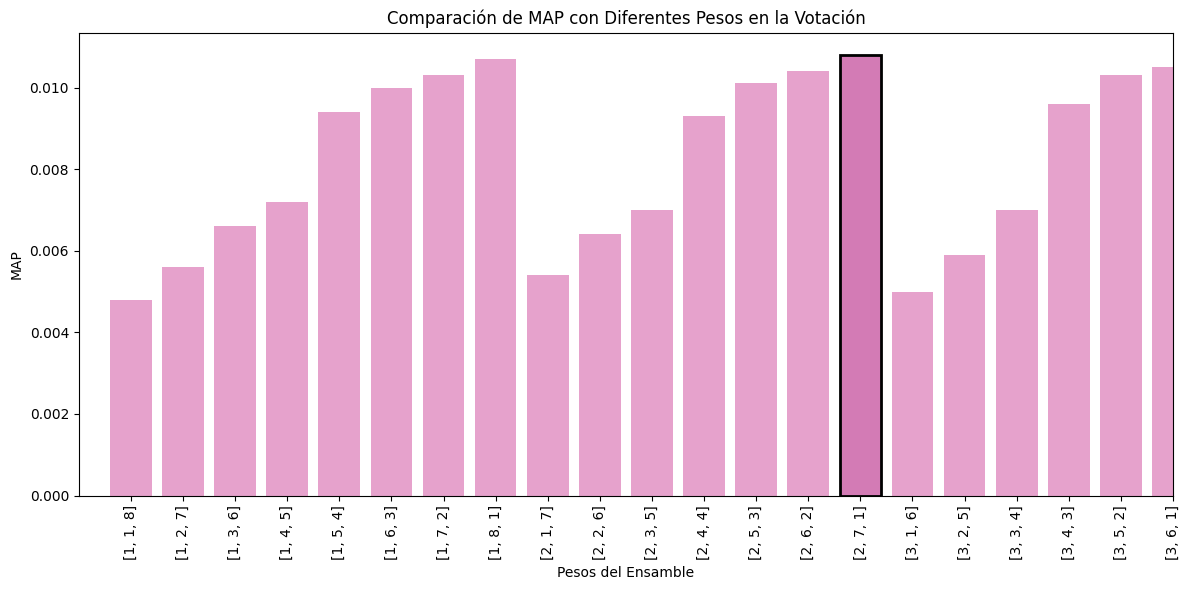

In [11]:
import matplotlib.pyplot as plt

# Datos de pesos y MAP
pesos = ['[1, 1, 8]', '[1, 2, 7]', '[1, 3, 6]', '[1, 4, 5]', '[1, 5, 4]', '[1, 6, 3]', '[1, 7, 2]',
         '[1, 8, 1]', '[2, 1, 7]', '[2, 2, 6]', '[2, 3, 5]', '[2, 4, 4]', '[2, 5, 3]', '[2, 6, 2]',
         '[2, 7, 1]', '[3, 1, 6]', '[3, 2, 5]', '[3, 3, 4]', '[3, 4, 3]', '[3, 5, 2]', '[3, 6, 1]',
         '[4, 1, 5]', '[4, 2, 4]', '[4, 3, 3]', '[4, 4, 2]', '[4, 5, 1]', '[5, 1, 4]', '[5, 2, 3]',
         '[5, 3, 2]', '[5, 4, 1]', '[6, 1, 3]', '[6, 2, 2]', '[6, 3, 1]', '[7, 1, 2]', '[7, 2, 1]',
         '[8, 1, 1]']

map_values = [0.0048, 0.0056, 0.0066, 0.0072, 0.0094, 0.0100, 0.0103, 0.0107, 0.0054, 0.0064, 0.0070,
              0.0093, 0.0101, 0.0104, 0.0108, 0.0050, 0.0059, 0.0070, 0.0096, 0.0103, 0.0105, 0.0053, 0.0069,
              0.0071, 0.0084, 0.0103, 0.0054, 0.0060, 0.0071, 0.0073, 0.0061, 0.0066, 0.0071, 0.0055, 0.0061,
              0.0050]

# Configuración que debe destacarse
best_index = map_values.index(0.0108)  # El índice de la mejor MAP (0.0108)

# Crear el gráfico
plt.figure(figsize=(12, 6))

# Colores: Rojo claro para todas las barras
base_color = '#e6a2cc'
best_color = '#d37bb5'  # Un color un poco más oscuro para la mejor barra

colors = [base_color if i != best_index else best_color for i in range(len(map_values))]

# Graficar las barras
bars = plt.bar(pesos, map_values, color=colors)

# Resaltar la barra "best" de alguna forma (por ejemplo, agregar un borde)
for bar in bars:
    if bar.get_height() == max(map_values):
        bar.set_edgecolor('black')  # Borde negro para resaltar la barra del mejor valor
        bar.set_linewidth(2)  # Grosor del borde

# Agregar etiquetas y título
plt.xlabel('Pesos del Ensamble')
plt.ylabel('MAP')
plt.title('Comparación de MAP con Diferentes Pesos en la Votación')

# Rotar etiquetas del eje x para mejor visibilidad
plt.xticks(rotation=90, ha='center')

# Fijar el rango del eje X para ver solo las diferencias relevantes
plt.xlim(-1, 20)  # Ajusta el rango según sea necesario

# Mostrar el gráfico
plt.tight_layout()
plt.show()

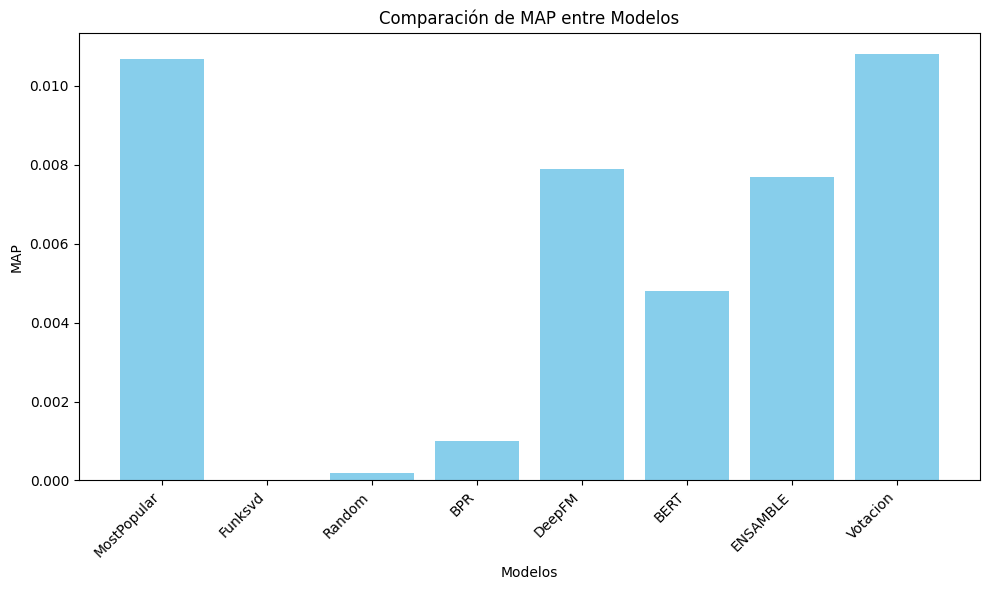

In [3]:
import matplotlib.pyplot as plt

# Datos
modelos = ['MostPopular', 'Funksvd', 'Random', 'BPR', 'DeepFM', 'BERT', 'ENSAMBLE', 'Votacion']
map_values = [0.01068, 0, 0.0002, 0.001, 0.0079, 0.0048, 0.0077, 0.0108]

# Crear el gráfico
plt.figure(figsize=(10, 6))
plt.bar(modelos, map_values, color='skyblue')

# Agregar etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('MAP')
plt.title('Comparación de MAP entre Modelos')

# Rotar etiquetas del eje x para mayor claridad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.tight_layout()
plt.show()